[View in Colaboratory](https://colab.research.google.com/github/Con-Mi/Deep-Learning-Projects/blob/master/Simple_Implementation_of_Densely_Connected_Neural_Networks.ipynb)

## Check my blog post [here](https://goosemi.wordpress.com/) for a more detail explanation of this model.

In [0]:
# Install PyTorch(version 4) and torchvision libraries
!pip install torch torchvision

In [0]:
"""
	The Network Class
"""

import torch
import torch.nn as nn
import math

class Dense_Block(nn.Module):
	def __init__(self, in_channels):
		super(Dense_Block, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = in_channels)

		self.conv1 = nn.Conv2d(in_channels = in_channels, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv4 = nn.Conv2d(in_channels = 96, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
		self.conv5 = nn.Conv2d(in_channels = 128, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)

    
	def forward(self, x):

		bn = self.bn(x)
		conv1 = self.relu(self.conv1(bn))

		conv2 = self.relu(self.conv2(conv1))
		c2_dense = self.relu(torch.cat([conv1, conv2], 1))

		conv3 = self.relu(self.conv3(c2_dense))
		c3_dense = self.relu(torch.cat([conv1, conv2, conv3], 1))

		conv4 = self.relu(self.conv4(c3_dense))
		c4_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4], 1))

		conv5 = self.relu(self.conv5(c4_dense))
		c5_dense = self.relu(torch.cat([conv1, conv2, conv3, conv4, conv5], 1))

		return c5_dense


class Transition_Layer(nn.Module):
	def __init__(self, in_channels, out_channels):
		super(Transition_Layer, self).__init__()

		self.relu = nn.ReLU(inplace = True)
		self.bn = nn.BatchNorm2d(num_features = out_channels)
		self.conv = nn.Conv2d(in_channels = in_channels, out_channels = out_channels, kernel_size = 1, bias = False)
		self.avg_pool = nn.AvgPool2d(kernel_size = 2, stride = 2, padding = 0)

	def forward(self, x):

		bn = self.bn(self.relu(self.conv(x)))
		out = self.avg_pool(bn)

		return out


class DenseNet(nn.Module):
	def __init__(self, nr_classes):
		super(DenseNet, self).__init__()

		self.lowconv = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 7, padding = 3, bias = False)
		self.relu = nn.ReLU()

		# Make Dense Blocks
		self.denseblock1 = self._make_dense_block(Dense_Block, 64)
		self.denseblock2 = self._make_dense_block(Dense_Block, 128)
		self.denseblock3 = self._make_dense_block(Dense_Block, 128)

		# Make transition Layers
		self.transitionLayer1 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer2 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 128)
		self.transitionLayer3 = self._make_transition_layer(Transition_Layer, in_channels = 160, out_channels = 64)

		# Classifier
		self.bn = nn.BatchNorm2d(num_features = 64)
		self.pre_classifier = nn.Linear(64*4*4, 512)
		self.classifier = nn.Linear(512, nr_classes)

	def _make_dense_block(self, block, in_channels):
		layers = []
		layers.append(block(in_channels))
		return nn.Sequential(*layers)

	def _make_transition_layer(self, layer, in_channels, out_channels):
		modules = []
		modules.append(layer(in_channels, out_channels))
		return nn.Sequential(*modules)

	def forward(self, x):
		out = self.relu(self.lowconv(x))

		out = self.denseblock1(out)
		out = self.transitionLayer1(out)

		out = self.denseblock2(out)
		out = self.transitionLayer2(out)

		out = self.denseblock3(out)
		out = self.transitionLayer3(out)
    
		out = self.bn(out)
		out = out.view(-1, 64*4*4)

		out = self.pre_classifier(out)
		out = self.classifier(out)

		return out


In [0]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [4]:
import time
import torch.optim as optim
from torch.autograd import Variable

# GPU flag
use_gpu = torch.cuda.is_available()

# Hyperparameters
batch_size = 10
momentum = 0.95
learning_rate = 0.001
nr_classes = 10
nr_epochs = 10
loss_vctr = []

# Load the model on the GPU
densenet = DenseNet(nr_classes)
if use_gpu:
  densenet.cuda()

# Data Loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

start = time.time()

# Oprimization Criteria and Optimization method
criterion = nn.CrossEntropyLoss().cuda() if use_gpu else nn.CrossEntropyLoss()
optimizer = optim.SGD(densenet.parameters(), lr=learning_rate, momentum=momentum, nesterov = False)

# Training Loop
print("Start of the Optimization Processs..")
for epoch in range(nr_epochs):  

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs = Variable(inputs).cuda() 
        labels = Variable(labels).cuda()
        
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = densenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            loss_vctr.append(running_loss / 2000)
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0
    
print("^^^^^^^^^^^^^^^^^")
print('Finished Optimization.')
end = time.time() # Time counted in seconds
print("The total time to train the model on the K80 GPU is : {:.1f} minutes.".format((end - start)/60))

Start of the Optimization Processs..
[1,  2000] loss: 1.578
[1,  4000] loss: 1.274
[2,  2000] loss: 1.009
[2,  4000] loss: 0.922
[3,  2000] loss: 0.795
[3,  4000] loss: 0.770
[4,  2000] loss: 0.668
[4,  4000] loss: 0.671
[5,  2000] loss: 0.598
[5,  4000] loss: 0.595
[6,  2000] loss: 0.532
[6,  4000] loss: 0.539
[7,  2000] loss: 0.476
[7,  4000] loss: 0.480
[8,  2000] loss: 0.418
[8,  4000] loss: 0.455
[9,  2000] loss: 0.385
[9,  4000] loss: 0.415
[10,  2000] loss: 0.344
[10,  4000] loss: 0.383
^^^^^^^^^^^^^^^^^
Finished Optimization.
The total time to train the model on the K80 GPU is : 30.5 minutes.


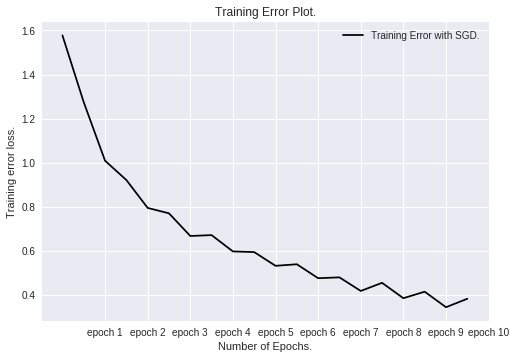

In [39]:
from matplotlib import pyplot as plt
import numpy as np

x = range(20)
x_epoch = [z for z in range(1, 21) if z%2 == 0] 
x_ticks_labels = ['epoch ' + str(x) for x in range(1, 11)]

plt.figure(1)
plt.plot(x, loss_vctr, color = 'k', label = "Training Error with SGD.")
plt.xticks(x_epoch, x_ticks_labels)
plt.title("Training Error Plot.")
plt.ylabel("Training error loss.")
plt.xlabel("Number of Epochs.")
plt.legend()
# plt.savefig("training_plot.png", dpi = 300)  If you want to save your plot, uncomment.
plt.show()

In [6]:
correct = 0
total = 0

for data in testloader:
        images, labels = data
        images = Variable(images).cuda()
        outputs = densenet(images)
        _, predicted = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
        
print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 79 %


In [13]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = densenet(images.cuda())
        _, predicted = torch.max(outputs, 1)
        c = (predicted.cpu() == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 79 %
Accuracy of   car : 87 %
Accuracy of  bird : 71 %
Accuracy of   cat : 63 %
Accuracy of  deer : 72 %
Accuracy of   dog : 71 %
Accuracy of  frog : 86 %
Accuracy of horse : 78 %
Accuracy of  ship : 89 %
Accuracy of truck : 91 %
